# Display objects/screens in the object list

In [1]:
import bigpemu_debug as bigp
import struct

"""
Code starts 0x00192000
"""
locations = {
    # The address to start at
    # The number of bytes to fetch
    "LaunchVLM":  (0x00192000, 0x800),
    "avbank":     (0x0019b0c8, 0x80),
    "draw_screen":(0x00148000, 0x4000),
    "dscreen":    (0x00f03f40, 0x8),
    "cscreen":    (0x00f03f44, 0x8),
    "_cscreen":   (0x00148000, 0x4000),
    "_dscreen":   (0x00100000, 0xF000),
    "__cscreen":  (0x00100000, 0x4000),
    "mods":       (0x00f03f48, 0x8),
    "gpumods":    (0x001a69c0, 0x32),
    "curmod":     (0x00f03000, 0x32),
    "beasties":   (0x001ae048, 0x64 * 12),
    "jaglogo":    (0x00199c48, 4492),
    "board":      (0x001b00f8, 0x8),
    "list":       (0x001ae81c, 624),
    "list1":      (0x1AE81C,624),
    "list2":      (0x1AE88C,624),
    "blist":      (0x1AEC7C,8),
    "dlist":      (0x1AEC80,8),
    "ddlist":     (0x1AEC84,8),
}

def send_hex_dump_cmd_raw(from_addr,dump_len):
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def send_hex_dump_cmd(location):
    from_addr,dump_len = locations[location]
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def dump_standard(hex_dump,WIDTH=32):
    mem = '\n'.join([
        ','.join(['{:02X}'.format(x) for x in hex_dump[l:l+WIDTH]]) 
        for l in range(0,len(hex_dump),WIDTH)
    ])
    return mem



## Launch BigPEmu and connect to the debug server

In [66]:
import socket
import os
import time

# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../src/bin/vlm.abs &")
time.sleep(5)

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 44123  # The port used by the server

# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


## Get the Object List

In [59]:
import cry_rgb as cry
from PIL import Image, ImageColor
import numpy as np
import matplotlib.pyplot as plt


obj_names = [
    "Bit Mapped Object",
    "Scaled Bit Mapped Object",
    "Graphics Processor Object",
    "Branch Object",
    "Stop Object",
    "Unused",
    "Unused",
    "Unused RAM",
]

obj_defs = {
    0: [ # Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
    ],
    1: [ #Scaled Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
            [ # Third Phrase
                (0,7, "HSCALE"),
                (8,15,"VSCALE"),
                (16,23,"REMAINDER"),
            ],
    ],
    2: [ # Graphics Processor Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,63,"DATA"),
            ],
    ],
    3: [ # Branch Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,15,"CC"),
                (16,23,"Unused"),
                (24,42,"LINK"),
            ],
    ],
    4: [ # Stop Object
            [
                (0,2,"Type"),
                (3,63,"DATA"),
            ],
    ],
    7: [ # Unused RAM
            [
                (0,2,"Type"),
                (3,63,"Unused RAM"),
            ],
    ],
}

# Extract the bits for each entry in the object.
get_bits = lambda o,start,end: (o >> start) & int('1' * ((end-start)+1),base=2)
def get_type(o): return get_bits(o,0,2)

def getPixels(cry_pixels,width=2):
    rgb_pixels = []
    for i in range(0, len(cry_pixels),2):
        t = cry_pixels[i:i+2]
        #print(i,t,int.from_bytes(t,'little'))
        rgb = cry.cry_to_rgb(int.from_bytes(t,'big'))
        rgb_pixels += [rgb]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len # Pad to our chosen width
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels

def get1BitPixels(cry_pixels,width=2):
    rgb_pixels = []
    for b in cry_pixels:
        for m in [128,64,32,16,8,4,2,1]:
            rgb_pixels += [(255,255,255) if (b & m) else (0,0,0)]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels


Get the current object list, print it out and store a copy so we can use it to retrieve the screen data.

In [67]:
# Get the address of the object list.
hex_dump = send_hex_dump_cmd("ddlist")
dd_addr = int.from_bytes(hex_dump[:4], byteorder='big', signed=False)

# Get the raw data of the object list.
hex_dump = send_hex_dump_cmd_raw(dd_addr,624)
obj_list_raw = dump_standard(hex_dump,WIDTH=8)
obj_list = obj_list_raw.split("\n")[1:-1]

# Parse out the object list entries.
i = 0
obj_list_data = []
while True:
    if i >= len(obj_list):
        break
    o = int(obj_list[i].replace(',',''),16)
    o_type = get_type(o)
    if o_type == 7:
        break
    assert(o_type in obj_defs)
    o_vals_print = []
    obj_data = {}
    print(obj_names[o_type])
    for o_map in obj_defs[o_type]:
        o = int(obj_list[i].replace(',',''),16)
        for start,end,description in o_map:
            o_val = get_bits(o,start,end)
            if description in ["DATA","LINK"]:
                o_val = hex(o_val << 3)
            o_vals_print += [f"{description}: {o_val}"]
            obj_data[description] = o_val
        i+=1
    obj_list_data += [obj_data]
    print('    ' + '\n    '.join(o_vals_print))

# Add the contents of the screen data to each object
# so we can work with it without the debugger running.
for o in obj_list_data:
    if "DWIDTH" not in o:
        continue
    data = bytearray()
    data_len = (o["DWIDTH"] * 8) * o["HEIGHT"]
    data_adr = int(o["DATA"],16)
    while len(data) < data_len:
        data += send_hex_dump_cmd_raw(data_adr,0xF000)
        data_adr += 0xF000
    data = data[:data_len]
    o["DATA_BYTES"] = data
    


Branch Object
    Type: 3
    YPOS: 507
    CC: 2
    Unused: 0
    LINK: 0x1ae800
Scaled Bit Mapped Object
    Type: 1
    YPOS: 0
    HEIGHT: 192
    LINK: 0x1ae840
    DATA: 0x14e300
    XPOS: 4088
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 24
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 0
    FIRSTPIX: 0
    HSCALE: 64
    VSCALE: 64
    REMAINDER: 1
Stop Object
    Type: 4
    DATA: 0x0
Bit Mapped Object
    Type: 0
    YPOS: 0
    HEIGHT: 384
    LINK: 0x1ae860
    DATA: 0x192000
    XPOS: 384
    DEPTH: 3
    PITCH: 1
    DWIDTH: 1
    IWIDTH: 1
    INDEX: 4
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 1
    FIRSTPIX: 0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Scaled Bit Mapped Object
    Type: 1
    YPOS: 0
    HEIGHT: 192
    LINK: 0x1ae880
    DATA: 0x14e3c0
    XPOS: 184
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 24
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 0
    RELEASE: 0
    FIRSTPIX

Let's examine the screen data in each of our objects!

In [130]:
hex(4088)

'0xff8'

192 192 36864
40 1920
192 192 36864
320 4480


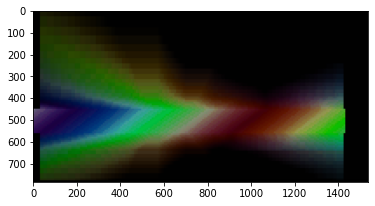

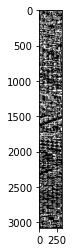

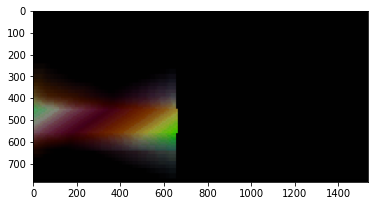

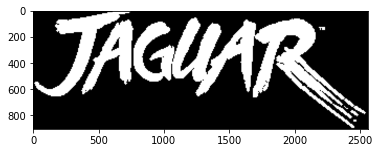

In [129]:
SCALE = 8
byte_depth = [1,]

def clip_data(data, data_width, clip_width, data_len):
    clipped_data = bytearray()
    for i in range(0,len(data), data_width):
        clipped_data += data[i:i+clip_width]
        if len(clipped_data) > data_len:
            break
    return clipped_data

for o in obj_list_data:
    if o["Type"] == 1:
        clip_width = o["IWIDTH"] * 8 * 2
        data_width = o["DWIDTH"] * 8
        image_height = o["HEIGHT"]
        image_width = o["IWIDTH"] * 8
        data_len = image_width * image_height
        print(image_width, image_height, data_len)
        data = o["DATA_BYTES"]
        data = clip_data(data, data_width, clip_width, data_len)
        pixels = getPixels(data,image_width)
        img = Image.fromarray(pixels,mode='RGB')
        img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
        plt.figure()
        plt.imshow(img)
        continue
        
    if o["Type"] == 0:
        width = o["INDEX"] * 10 # This is wrong.
        height = o["HEIGHT"]
        data_len = int((width * height)/8)
        data = o["DATA_BYTES"][:data_len]
        print(width, data_len)
        width = width
        pixels = get1BitPixels(data,width)
        img = Image.fromarray(pixels,mode='RGB')
        img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
        plt.figure()
        plt.imshow(img)
        continue


# Rough Work